In [1]:
# set-up -- do not change
import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
npr.seed(1)

# Question 4.1 (6 pts)

> In this question, we will look at the optimal aim location when playing a modified game of darts.

Assume you are playing a game of darts, that is you need to throw a dart at a target a couple of meters away from you. For simplicity, we assume this is a modified version of the game in which the target board comprises of a series of vertical bands, so that only the horizontal landing location of the dart matters. Landing the dart on each different sector is associated with a different score.

We measure horizontal location starting from the center of the dart board ($0$ cm), with negative numbers meaning a position to the left of the center and positive numbers a position to the right of the center. We ignore the vertical position, assuming the bands are tall enough to be easy to hit on the vertical axis.

The sectors are characterized by their bounds on the board (start and end location) and their score, as follows:

- -25 to -15 cm: 15 points.
- -15 to -5 cm: 10 points.
- -5 to 5 cm: 20 points.
- 5 to 15 cm: 5 points.
- 15 to 25 cm: 25 points.

If the dart lands outside the board, you would get 0 points.

Given the aim location $\hat{s}$, we assume that due to motor noise, the actual *hit* location $r$ (where the dart actually lands) is distributed as follows:
$$
p(r|\hat{s}) = (1-\lambda) \mathcal{N}\left(r; \hat{s},\sigma^2_\text{motor}\right) + \lambda \mathcal{N}\left(r; \hat{s},\sigma^2_\text{lapse}\right),
$$
where $\sigma_\text{motor}$ is the standard spread location due to motor error and throwing variability. The novelty of this equation is that we also consider a probability $\lambda \in [0, 1]$ of lapsing (e.g., sneezing or being distracted by a friend while throwing), which produces a bad throw with a larger error $\sigma_\text{lapse}$. For this exercise, we assume $\sigma_\text{lapse} = 20$ cm.

Write a function that computes the expected score as a function of aim location $\hat{s}$ and task parameters $\left(\sigma_\text{motor}, \lambda, \sigma_\text{lapse}\right)$. Then, write a function that for given task parameters $\left(\sigma_\text{motor}, \lambda, \sigma_\text{lapse}\right)$, returns the optimal aim location $s^\star$ (the aim point which produces the maximum expected score).

- a) For $\sigma_\text{motor} \in [2, 10]$ cm and $\lambda \in [0, 0.2]$, what are the rightmost (maximum) and leftmost (minimum) locations for $s^\star$?
- b) For $\lambda = 0.1$, plot $s^\star$ as a function of $\sigma_\text{motor}$, for $\sigma_\text{motor} \in [2, 10]$ cm. You should see an interesting switch of optimal strategy. Around which value of $\sigma_\text{motor}$ the optimal strategy switches and it becomes more convenient to throw the dart to the left of the center as opposed to the right of the center?

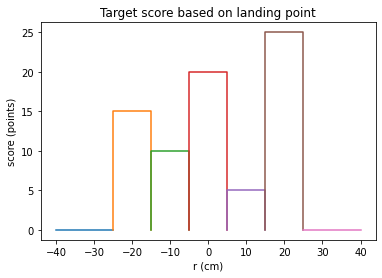

In [2]:
bands = [-np.inf,-25,-15,-5,5,15,25,np.inf]
scores = [0,15,10,20,5,25,0]

# Plot target score

s = np.linspace(-30,30,200)
for index, band in enumerate(scores):
    a = np.maximum(bands[index], -40)
    b = np.minimum(bands[index+1], 40)
    plt.plot((a,a,b,b),np.array((0,scores[index],scores[index],0)))

plt.xlabel('r (cm)')
plt.ylabel('score (points)')
plt.title('Target score based on landing point')
plt.show()

In [3]:
from pybads import BADS
sigma_lapse = 20


# Calculate score based on landing point
def calculate_score(r):
    for i, (start, end) in enumerate(zip(bands[:-1], bands[1:])):
        if start < r <= end:
            return scores[i]
    return 0

# Expected score function
def expected_score(s_hat, sigma_motor, lam, sigma_lapse):
    integrand = lambda r: ((1 - lam) * sps.norm.pdf(r, s_hat, sigma_motor) + lam * sps.norm.pdf(r, s_hat, sigma_lapse)) * calculate_score(r)
    result, _ = sp.integrate.quad(integrand, -np.inf, np.inf)
    return -result  


def optimize_aim(sigma_motor, lam):
    # Wrapper function to include additional parameters
    def wrapped_expected_score(s_hat):
        return expected_score(s_hat[0], sigma_motor, lam, sigma_lapse)

    start_point = [0]  
    lower_bound = [-30] 
    upper_bound = [30]  

    optimizer = BADS(wrapped_expected_score, start_point, lower_bound, upper_bound)
    result = optimizer.optimize()
    optimal_solution = result.x

    return optimal_solution[0]  

# Analysis over ranges
sigma_motor_range = np.linspace(2, 10, 5) 
lambda_range = np.linspace(0, 0.2, 5) 

optimal_aims = []
for sigma_motor in sigma_motor_range:
    for lam in lambda_range:
        optimal_aim = optimize_aim(sigma_motor, lam)
        optimal_aims.append(optimal_aim)

max_optimal_aim = max(optimal_aims)
min_optimal_aim = min(optimal_aims)

print("Rightmost (maximum) optimal aim location: {}".format(max_optimal_aim))
print("Leftmost (minimum) optimal aim location: {}".format(min_optimal_aim))

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2        -19.8448               1                                 Uncertainty test
     0           4        -19.8448               1         Initial mesh            Initial points
     0           6        -19.8448             0.5         Refine grid             Train
     1          11        -19.8448            0.25         Refine grid             Train
     2          12        -24.6349            0.25     Successful search (ES-ell)        
     2          13        -24.6593            0.25     Incremental search (ES-ell)        
     2          14        -24.7225            0.25     Incremental search (ES-ell)        
     2          19        -24.7225           0.125         Refine grid             

C:\Users\matin\AppData\Local\Temp\ipykernel_19604\2074636366.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = sp.integrate.quad(integrand, -np.inf, np.inf)


     1          11         -19.001            0.25         Refine grid             Train
     2          12        -23.1046            0.25     Successful search (ES-wcm)        
     2          13        -23.1304            0.25     Incremental search (ES-wcm)        
     2          14         -23.183            0.25     Incremental search (ES-wcm)        
     2          19         -23.183           0.125         Refine grid             
     3          20        -23.1831           0.125     Incremental search (ES-wcm)        
     3          21        -23.1831           0.125     Incremental search (ES-wcm)        
     3          24        -23.1831          0.0625         Refine grid             
     4          29        -23.1831         0.03125         Refine grid             Train
     5          30        -23.1831         0.03125     Incremental search (ES-ell)        
     5          31        -23.1831         0.03125     Incremental search (ES-wcm)        
     5          32

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2         -19.001               1                                 Uncertainty test
     0           4         -19.001               1         Initial mesh            Initial points
     0           6         -19.001             0.5         Refine grid             Train


C:\Users\matin\AppData\Local\Temp\ipykernel_19604\2074636366.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = sp.integrate.quad(integrand, -np.inf, np.inf)


     1          11         -19.001            0.25         Refine grid             Train
     2          12        -23.0816            0.25     Successful search (ES-wcm)        
     2          13         -23.134            0.25     Incremental search (ES-wcm)        
     2          14        -23.1829            0.25     Incremental search (ES-wcm)        
     2          19        -23.1829           0.125         Refine grid             
     3          20        -23.1829           0.125     Incremental search (ES-ell)        
     3          24        -23.1829          0.0625         Refine grid             
     4          27         -23.183          0.0625     Incremental search (ES-wcm)        
     4          29         -23.183         0.03125         Refine grid             Train
     5          32        -23.1831         0.03125     Incremental search (ES-wcm)        
     5          34        -23.1831       0.0078125         Refine grid             
Optimization terminated: 

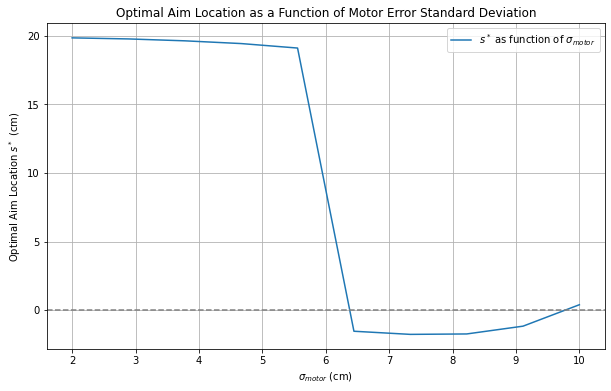

In [4]:
lam = 0.1  

sigma_motor_values = np.linspace(2, 10, 10)  

# Store optimal aim locations for each sigma_motor
optimal_aims = []

for sigma_motor in sigma_motor_values:
    optimal_aim = optimize_aim(sigma_motor, lam)
    optimal_aims.append(optimal_aim)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(sigma_motor_values, optimal_aims, label='$s^*$ as function of $\sigma_{motor}$')
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel('$\sigma_{motor}$ (cm)')
plt.ylabel('Optimal Aim Location $s^*$ (cm)')
plt.title('Optimal Aim Location as a Function of Motor Error Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
for i in range(1, len(optimal_aims)):
    if optimal_aims[i-1] * optimal_aims[i] < 0:
        f = sp.interpolate.interp1d([optimal_aims[i-1], optimal_aims[i]], [sigma_motor_values[i-1], sigma_motor_values[i]])
        switch_point = f(0).item()
        print(f"Exact switch point at: \(\sigma_{{motor}}\) = {switch_point:.15f} cm")
        break

Exact switch point at: \(\sigma_{motor}\) = 6.378437113574401 cm


# Question 4.2 (6 pts)

> In this question, we will infer the empirical loss function of an observer in a task based on their responses.

In each trial of this experiment, the participant is shown a cloud of dots on a screen. The horizontal location of each dot is drawn from the following mixture distribution:
  $$
  p(s; h) = 0.8 \mathcal{N}\left(s; 0, 0.2^2\right) + 0.2 \mathcal{N}\left(s; h, 0.2^2\right)
  $$
  where $h$ is a parameter controlled by the experimenter, and is changed from trial to trial. The horizontal location is measured in normalized screen units $s \in [-1, 1]$, where $0$ is the center of the screen. 
- Along the vertical axis, the dots show a small jitter along the center of the screen (we ignore the vertical displacement).
- In each trial, the subject is asked to report the horizontal position of the *center* of the cloud of dots. The word "center" is ambiguous, as we could be asking for the mean, the median, or other [measures of central tendency](https://en.wikipedia.org/wiki/Central_tendency). The question is what the subject would naturally report. We assume the subject reports the estimate $\hat{s}$ that minimizes their expected loss. 
- For the purpose of this question, we also assume that the observer's loss function takes the parametric form
  $$
  \mathcal{L}_\alpha\left(s^\prime, s \right) = \left| s^\prime - s \right|^\alpha
  $$
  which is the loss for reporting $s^\prime$ for a dot position $s$. 
- In each trial, the expected loss is the expectation of the loss over the presented dot locations, $p(s; h)$.
- A sequence of trials is thus represented by the trial design (the presented distribution of dots, parameterized by $h_t$) and the observer's responses $\hat{s}_t$ in each trial $t$.
- For simplicity, here we assume that there is no response noise.

------------------

- a) First, as a sanity check, compute the *expected loss* assuming $\alpha = 1$, a fixed value of $h = 0.3$ and a candidate estimate $s^\prime = 0.5$. In formulas:
$$
\mathbb{E}\left[ \mathcal{L}_\alpha\left(s^\prime, s \right) \right] = \int p(s; h) \mathcal{L}_\alpha\left(s^\prime, s \right) ds
$$
  where you should replace the pdf and the loss with the definitions provided in the text of the exercise.
  Report the expected loss for this specific case in Moodle.
- b) Now, as a further sanity check, for same case $\alpha = 1$ and $h = 0.3$, report the *optimal estimate*, that is the estimate $s^\star$ that minimizes the expected loss. In formulas:
$$
s^\star = \arg\min_{s^\prime} \mathbb{E}\left[ \mathcal{L}_\alpha\left(s^\prime, s \right) \right]
$$
  Report the optimal estimate for this specific case in Moodle.
- c) Given the data reported below, infer the exponent $\alpha \ge 0$ of the loss function that best describes the subject behavior. Do so by finding the $\alpha$ that minimizes the total squared error between the model predictions (assuming the observer follows Bayesian decision theory) and the data, summed over trials. Report the best estimate for $\alpha$ in Moodle (error tolerance $\pm 0.1$).

*Notes*: 
- Assume that the horizontal location $s \in [-1, 1]$ (i.e., within the width of the screen).
- In real data, the observer's responses would be corrupted by decision and motor noise, which would make inferring the loss function still more complex. For example, it would be better to use Bayesian inference to infer a posterior over $\alpha$, as opposed to a point estimate. Still, the logic would be the same.

In [6]:
# For part c - trial parameters h_t and subject's responses s_hat_t

h_t = np.array([-0.0663824 ,  0.17625959, -0.3999085 , -0.15813394, -0.28259529,
       -0.32612912, -0.25099183, -0.12355142, -0.08258602,  0.03105339,
       -0.06464439,  0.1481756 , -0.2364382 ,  0.30249395, -0.37808993,
        0.13637401, -0.06615616,  0.04695186, -0.28769045, -0.24151881])
s_hat_t = np.array([-0.0125   ,  0.034375 , -0.0734375, -0.03125  , -0.0546875,
       -0.0609375, -0.0484375, -0.025    , -0.0171875,  0.00625  ,
       -0.0125   ,  0.0296875, -0.0453125,  0.0578125, -0.0703125,
        0.0265625, -0.0125   ,  0.009375 , -0.0546875, -0.046875 ])

In [7]:
from pybads import BADS

alpha = 1
h = 0.3
s_prime = 0.5


p1 = 0.8  
p2 = 0.2  
std_dev = 0.2  

# Loss function
def loss_function(s, s_prime, alpha):
    return np.abs(s_prime - s)**alpha

# Mixture distribution probability density function
def mixture_pdf(s, h):
    return p1 * sps.norm.pdf(s, 0, std_dev) + p2 * sps.norm.pdf(s, h, std_dev)


N = 2**10  
s = np.linspace(-1, 1, N+1)  

# Compute the integrand at each sample point
integrand_values = mixture_pdf(s, h) * loss_function(s, s_prime, alpha)
dx = s[1] - s[0]

expected_loss_value = sp.integrate.romb(integrand_values, dx)
print("The expected loss for s' = {} is {}".format(s_prime ,expected_loss_value ))


The expected loss for s' = 0.5 is 0.4472804836371662


In [8]:
def expected_loss(s_prime_array, h=0.3, alpha=1):
    s_prime = s_prime_array[0]
    integrand_values = mixture_pdf(s, h) * loss_function(s, s_prime, alpha)
    dx = s[1] - s[0]  
    result = sp.integrate.romb(integrand_values, dx)
    return result

# Optimization function using BADS
def find_optimal_estimate(h):
    start_point = [0]  
    lower_bound = [-1] 
    upper_bound = [1]  
    optimizer = BADS(lambda s_prime: expected_loss(s_prime, h), start_point, lower_bound, upper_bound)
    result = optimizer.optimize()
    optimal_estimate = result.x[0]
    return optimal_estimate


optimal_estimate = find_optimal_estimate(h)
print("Optimal estimate s* = {}".format(optimal_estimate))

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2        0.189957               1                                 Uncertainty test
     0           4        0.189957               1         Initial mesh            Initial points
     0           6        0.189957             0.5         Refine grid             Train
     1           7        0.188892             0.5     Incremental search (ES-wcm)        
     1           8        0.188819             0.5     Incremental search (ES-wcm)        
     1           9        0.188571             0.5     Incremental search (ES-wcm)        
     1          11        0.188571            0.25         Refine grid             
     2          12        0.186039            0.25     Incremental search (ES-ell)     

In [10]:
def total_squared_error(alpha):
    total_error = 0
    for h, s_hat in zip(h_t, s_hat_t):
        s_prime_opt = sp.optimize.minimize(lambda s_prime: expected_loss(s_prime, h, alpha), 0, bounds=[(-1, 1)]).x[0]
        total_error += (s_prime_opt - s_hat)**2
    return total_error

# Minimize the total squared error to find the best alpha
result = sp.optimize.minimize_scalar(total_squared_error, bounds=(0, 5), method='bounded')

best_alpha = result.x
print('The 𝛼 that minimizes the total squared error is {} : '.format(best_alpha))

The 𝛼 that minimizes the total squared error is 1.697608976616262 : 


# Question 4.3 (18 pts)

> For this question, which amounts to a small modelling and model fitting project, we will put together several topics seen in the course. Using the data of the sensorimotor timing experiment \[**AWV12**\] that we encountered several times in this course, we will use a Bayesian observer model to recover the observer's prior from their responses.

We analyze the data with the `gaussianmixobserverwithlapse` model, defines as follows:

- We assume the observer builds a (mismatched) Gaussian prior with two components:
  $$p(s) = w_\text{prior} \mathcal{N}\left(s| \mu_{\text{prior}}, \sigma_{\text{prior}, 1}^2 \right) + 
  \left(1 - w_\text{prior} \right)\mathcal{N}\left(s| \mu_{\text{prior}}, \sigma_{\text{prior}, 2}^2 \right)$$ 
  over the stimuli (time intervals). We assume the two components have the same mean $\mu_\text{prior}$, but different weights ($w_\text{prior}$ and $1 - w_\text{prior}$) and standard deviations ($\sigma_{\text{prior}, 1}$ and $\sigma_{\text{prior}, 2}$).
- We assume that the measurement distribution and likelihood are also Gaussian, $p(x|s) = \mathcal{N}\left(x| s, \sigma^2 \right)$.
- The observer uses the *posterior mean* estimator for the value of the stimulus, $\hat{s}_\text{PM}$.
- Gaussian motor response noise is added to the estimate, $p(r|\hat{s}) = \mathcal{N}\left(r| \hat{s}, \sigma_\text{motor}^2 \right)$. For this exercise, we assume that $\sigma_\text{motor} = 70$ ms for all subjects.
- In each trial, the observer lapses with probability $\lambda$ (the *lapse rate*), in which case the response is drawn from $p_\text{lapse}(r) = \text{Uniform}\left(r; 0, 1500 \right)$ ms. Otherwise, the observer responds normally (according to $p(r|\hat{s})$ described above) with probability $1 - \lambda$. 
- The free parameters of this model are $\mathbf{\theta} = \left(\sigma, \lambda, w_\text{prior}, \mu_\text{prior}, \sigma_{\text{prior}, 1}, \sigma_{\text{prior}, 2} \right)$.

Note that the parameters $w_\text{prior}, \mu_\text{prior}, \sigma_{\text{prior}, 1}, \sigma_{\text{prior,2}}$ model the subject's prior. In other words, we can use the estimates of these parameters to visualize what the subject's prior might look like.

-----------------------------------------------

For this analysis, we will separately consider all subjects, but for all subjects' datasets we will discard the first session, to ensure that subjects have achieved enough training in the task. We provide below example code that retrieves the stimuli $\mathbf{s}$ and responses $\mathbf{r}$ for a subject, withouth the first session.

- a) As a sanity check, compute the log-likelihood of model parameter $\theta_\star = \left(\sigma = 100, \lambda = 0.01, w_\text{prior} = 0.5, \mu_\text{prior} = 787, \sigma_{\text{prior}, 1} = 100, \sigma_{\text{prior}, 2} = 120 \right)$ for the dataset of subject 5 (having removed the first session) and report the result in Moodle.
- b) Separately fit the `gaussianmixobserverwithlapse` model to all the six subjects' datasets (removing the first session from all data) via maximum-likelihood estimation. For each subject, report the maximum log-likelihood value in Moodle.
- c) Consider now the `idealgaussianobserverwithlapse` observer model. The `idealgaussianobserverwithlapse` is the same as the model above with the difference that the observer's prior is a single Gaussian $p(s) = \mathcal{N}\left(s | \mu_\text{prior}, \sigma^2_\text{prior} \right)$ with $\mu_\text{prior} = 787.5$ ms and $\sigma_{\text{prior}} = 128.1$ ms. As above, we fix $\sigma_\text{motor} = 70$ ms. The `idealgaussianobserverwithlapse`  model has two free parameters, $\theta = \left(\sigma, \lambda \right)$. As a sanity check, compute the log-likelihood of model parameter $\theta_\star = \left(\sigma = 100, \lambda = 0.01\right)$ for the dataset of subject 5 (having removed the first session) and report the result in Moodle.
- d) Separately fit the `idealgaussianobserverwithlapse` model to all the six subjects' datasets (removing the first session from all data) via maximum-likelihood estimation.  For each dataset, separately compute the AIC and BIC for the two models `gaussianmixobserverwithlapse` and `idealgaussianobserverwithlapse`. Sum the AIC and BIC values across subjects to find the sum AIC (or BIC) of the two models. Report the summed AIC (and BIC) for the two models separately in Moodle.
- e) Which model is best, according to the metrics, and why do you think it is the case? Discuss your findings (max 300 words).

*Hints*:
- Both in parts (a) and (c), the log-likelihoods that you find should be between $-6000$ and $-5800$.
- There is an analytical solution for the posterior (and $\hat{s}_\text{PM}$), but there is no analytical solution for the response distribution $p(r|s)$, so you will need to use numerical integration at least to compute the response distribution.
- Finding the maximum-likelihood solution can be difficult as the optimization landscape is nontrivial. As a sanity check, verify that your solutions are consistent across different runs. If not, you might need to run additional optimization runs to increase the chance of finding the global optimum - possibly of the order of ten or even more.
- Beware that running multiple optimizations for all subjects will take quite some time (easily 30-60 minutes overall, possibly more - depending on your code, your computer, and how many runs you do). Model fitting is time consuming!
- Remember that you can ask questions in the Moodle discussion forum if you need further hints.
- For this problem, you are given unlimited attempts in Moodle.

In [32]:
import numpy as np
import numpy.random as npr
import scipy as sp
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
# week 3 and 4

# Load data of Experiment 3 of [AWV12] from .csv file to a Pandas dataframe
df = pd.read_csv('https://raw.githubusercontent.com/lacerbi/prob-cog-mod-files/main/data/awv12_exp3.csv')

# Remove unused columns
df.drop(df.columns[[6, 7, 8]], axis=1, inplace=True)

# Remove rows with NaNs
df.dropna(axis=0, inplace=True)

# Example code to take the data of subject 1, excluding the first session
subject = 1
s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])

In [25]:
# part a):
def gaussian_response(s, sigma, w_prior, mu_prior, sigma_prior_1, sigma_prior_2, sigma_motor):
    """
    Compute the mean and standard deviation of the response distribution
    given a stimulus `s` and sensory noise `sigma`, incorporating a mixture prior.
    """
    sigma_eff = (w_prior * (sigma_prior_1**2)) + ((1 - w_prior) * (sigma_prior_2**2))
    w_main = sigma_eff / (sigma**2 + sigma_eff)
    mu_resp = w_main*s + (1 - w_main)*mu_prior
    sigma_resp = np.sqrt(w_main**2*sigma**2 + sigma_motor**2)
    return mu_resp, sigma_resp

# Function to compute the log-likelihood for the model with a mixture prior
def gaussianmixobserverwithlapse(theta, s_vec, r_vec):
    sigma, lapse_rate, w_prior, mu_prior, sigma_prior_1, sigma_prior_2 = theta
    sigma_motor = 70
    lapse_pdf = 1/1500
    
    mu_resp, sigma_resp = gaussian_response(s_vec, sigma, w_prior, mu_prior, sigma_prior_1, sigma_prior_2, sigma_motor)
    loglike_vec = sps.norm.logpdf(r_vec,mu_resp,sigma_resp)
    likelihood_vec = np.exp(loglike_vec)
    likelihood_with_lapse_vec = (1-lapse_rate)*likelihood_vec + lapse_rate * lapse_pdf
    loglike_vec = np.log(likelihood_with_lapse_vec)
    return np.sum(loglike_vec)
   
    
theta_star = (100, 0.01, 0.5, 787, 100, 120)
subject = 5
s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])

# Compute log likelihood
loglike = gaussianmixobserverwithlapse(theta_star, s, r)
print('The log-likelihood of theta* for subject 5 is: {:.15}'.format(loglike))

The log-likelihood of theta* for subject 5 is: -5971.35896678819


In [33]:
use_pybads = True
if use_pybads:
    from pybads.bads import BADS
    method = 'BADS'
else:
    method = 'L-BFGS-B'
    
def multioptimize(target_fun, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, num_runs=20, method='L-BFGS-B'):
    """Simple function for multi-start optimization."""
    num_params = lower_bounds.shape[0]
    theta_res = np.zeros((num_runs, num_params))
    nll_res = np.zeros(num_runs)
    
    for index in range(num_runs):
        if index == 0:
            theta0 = 0.9 * (plausible_lower_bounds + plausible_upper_bounds)
        else:
            theta0 = np.random.uniform(low=plausible_lower_bounds, high=plausible_upper_bounds)
        
        if method == 'L-BFGS-B':
            bounds = sp.optimize.Bounds(lower_bounds, upper_bounds, True)  # Set hard bounds
            res = sp.optimize.minimize(target_fun, theta0, method='L-BFGS-B', bounds=bounds, options={'ftol': 1e-9, 'gtol': 1e-9})
            nll_res[index] = res.fun
            theta_res[index] = res.x
        elif method == 'BADS':
            bads = BADS(target_fun, theta0, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds)
            res = bads.optimize()
            nll_res[index] = res.fval
            theta_res[index] = res.x
        else:
            raise ValueError('Unknown optimization method.')
        print('Run {}: log-likelihood {}'.format(index, -nll_res[index]))
        
    idx_best = np.argmin(nll_res)
    nll_best = nll_res[idx_best]
    theta_best = theta_res[idx_best]
    return nll_best, theta_best

In [27]:
# part b):
lower_bounds = np.array([1, 0., 0, 1, 1, 1])
upper_bounds = np.array([2000, 0.08, 1, 2000, 2000, 2000])
plausible_lower_bounds = np.array([1, 0.001, 0.1, 700, 50, 50])  
plausible_upper_bounds = np.array([1000, 0.05, 0.9, 900, 150, 150])  


num_runs = 3

results = []

for subject in range(1, 7):  
    s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
    r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
    target_fun = lambda theta_: -gaussianmixobserverwithlapse(np.array(theta_), s, r)
    nll_best, theta_best = multioptimize(target_fun, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, num_runs, method=method)
    results.append((subject, theta_best, -nll_best))

for result in results:
    subject, theta_best, nll_best = result
    print('The maximum-likelihood solution (dataset S{}) is theta_ML = {} with log-likelihood: {}'.format(subject, theta_best, nll_best))

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Variables (index) internally transformed to log coordinates: [[0 0]]
Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2         20953.9               1                                 Uncertainty test
     0          10         11676.6               1         Initial mesh            Initial points


D:\anaconda\lib\site-packages\pybads\variable_transformer\variables_transformer.py:197: RuntimeWarning: overflow encountered in exp
  np.minimum(np.finfo(np.float64).max, np.exp(gamma * y + mu)),


     0          21         11595.8               1       Successful poll           Train
     1          37         11561.7               1       Successful poll           Train
     2          40         11524.2               1     Successful search (ES-wcm)        
     2          42           11522               1     Successful search (ES-wcm)        
     2          47         11521.9               1     Incremental search (ES-wcm)        
     2          59         11521.9             0.5         Refine grid             Train
     3          61         11521.4             0.5     Successful search (ES-wcm)        
     3          81         11521.4            0.25         Refine grid             Train
     4          83         11521.3            0.25     Successful search (ES-ell)        
     4          85           11521            0.25     Successful search (ES-ell)        
     4          87         11520.6            0.25     Successful search (ES-ell)        
     4       

In [34]:
# part c
def gaussian_response_ideal(s, sigma):
    """
    Compute the mean and standard deviation of the response distribution
    given a stimulus `s` and sensory noise `sigma`.
    """
   
    mu_prior = 787.5  
    sigma_prior = 128.1  # std of the Gaussian prior
    sigma_motor = 70  # Motor noise is fixed at 70 ms for all subjects
    
    # Compute mean and std of the response
    w = sigma_prior**2 / (sigma_prior**2 + sigma**2)
    mu_resp = w * s + (1 - w) * mu_prior
    sigma_resp = np.sqrt(w**2 * sigma**2 + sigma_motor**2)
    return mu_resp, sigma_resp

def ideal_gaussian_observer_with_lapse_loglike(theta, s_vec, r_vec):
    """
    Compute the log-likelihood of the ideal Gaussian observer with lapse model.
    """
    sigma, lapse_rate = theta
    mu_resp, sigma_resp = gaussian_response_ideal(s_vec, sigma)
    loglike_vec = sps.norm.logpdf(r_vec, mu_resp, sigma_resp)
    likelihood_vec = np.exp(loglike_vec) 
    likelihood_with_lapse_vec = (1 - lapse_rate) * likelihood_vec + lapse_rate * lapse_pdf
    loglike_vec = np.log(likelihood_with_lapse_vec)
    return np.sum(loglike_vec)

subject = 5
s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])

# Compute log-likelihood for theta* = (sigma=100, lambda=0.01)
theta_star = (100, 0.01)
loglike = ideal_gaussian_observer_with_lapse_loglike(theta_star, s, r)
print(f'The log-likelihood of theta* for subject {subject} is: {loglike}')

The log-likelihood of theta* for subject 5 is: -5950.256415040455


In [30]:
#part d):
lower_bounds = np.array([1, 0., 0, 1, 1, 1])
upper_bounds = np.array([2000, 0.08, 1, 2000, 2000, 2000])
plausible_lower_bounds = np.array([1, 0.001, 0.1, 700, 50, 50])  
plausible_upper_bounds = np.array([1000, 0.05, 0.9, 900, 150, 150])  



sum_aic, sum_bic = 0, 0 

for subject in range(1, 7):  # Loop over subjects
    # Extract data for each subject, excluding the first session
    s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
    r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
    target_fun = lambda theta: -gaussianmixobserverwithlapse(theta, s, r)
    nll_best, theta_best = multioptimize(target_fun, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, num_runs=3, method=method)

    k = len(theta_best)  
    n = len(s)  
    aic = 2*k - 2*(-nll_best)
    bic = np.log(n)*k - 2*(-nll_best)

    sum_aic += aic
    sum_bic += bic

    print('Subject {}: Best-fit parameters: {}, NLL: {}, AIC: {}, BIC: {}'.format(subject, theta_best, nll_best, aic, bic))

print("Summed AIC across all subjects is {}:".format(sum_aic))
print("Summed BIC across all subjects is {}".format(sum_bic))

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Variables (index) internally transformed to log coordinates: [[0 0]]
Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2         20953.9               1                                 Uncertainty test
     0          10         11676.6               1         Initial mesh            Initial points
     0          21         11595.8               1       Successful poll           Train
     1          25         11592.1               1     Successful search (ES-wcm)        
     1          33         11567.9               1     Successful search (ES-wcm)        
     1          35         11552.5               1     Successful search (ES-ell)        
     1          36         11531.6               1     Successful search (ES-ell)        
     1         

In [18]:
# part d):
lower_bounds = np.array([1, 0.])
upper_bounds = np.array([200, 1.])
plausible_lower_bounds = np.array([10, 0.01])
plausible_upper_bounds = np.array([100, 0.1])


sum_aic, sum_bic = 0, 0  
for subject in range(1, 7):  
    s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
    r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
    target_fun = lambda theta: -ideal_gaussian_observer_with_lapse_loglike(theta, s, r)
    nll_best, theta_best = multioptimize(target_fun, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, num_runs=3, method=method)

    k = len(theta_best) 
    n = len(s)  
    aic = 2*k - 2*(-nll_best)
    bic = np.log(n)*k - 2*(-nll_best)

    sum_aic += aic
    sum_bic += bic

    print('Subject {}: Best-fit parameters: {}, NLL: {}, AIC: {}, BIC: {}'.format(subject, theta_best, nll_best, aic, bic))

print("Summed AIC across all subjects is {}:".format(sum_aic))
print("Summed BIC across all subjects is {}".format(sum_bic))

Variables (index) internally transformed to log coordinates: [[0 0]]
Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2         11780.3               1                                 Uncertainty test
     0           6         11710.7               1         Initial mesh            Initial points
     0           7         11643.1               1       Successful poll           Train
     1          10         11624.5               1     Successful search (ES-wcm)        
     1          13         11624.4               1     Incremental search (ES-wcm)        
     1          17         11624.4             0.5         Refine grid             
     2          18         11624.3             0.5     Incremental search (ES-wcm)        
     2          24         11624.3            0.25         Refine grid             
     3          31         11624.3           0.125 

In [36]:
lower_bounds = np.array([1, 0.])
upper_bounds = np.array([2000, 0.08])
plausible_lower_bounds = np.array([1, 0.001])  
plausible_upper_bounds = np.array([1000, 0.05])  


num_runs = 3

results = []

for subject in range(1, 7):  # Looping through subjects 1 to 6
    s = np.array(df['Stimulus (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
    r = np.array(df['Response (ms)'][(df['Subject id'] == subject) & (df['Session id'] > 1)])
    target_fun = lambda theta_: -ideal_gaussian_observer_with_lapse_loglike(np.array(theta_), s, r)
    nll_best, theta_best = multioptimize(target_fun, lower_bounds, upper_bounds, plausible_lower_bounds, plausible_upper_bounds, num_runs, method=method)
    results.append((subject, theta_best, -nll_best))

for result in results:
    subject, theta_best, nll_best = result
    print('The maximum-likelihood solution (dataset S{}) is theta_ML = {} with log-likelihood: {}'.format(subject, theta_best, nll_best))

bads:TooCloseBounds: For each variable, hard and plausible bounds should not be too close. Moving plausible bounds.
Variables (index) internally transformed to log coordinates: [[0 0]]
Beginning optimization of a DETERMINISTIC objective function

 Iteration    f-count         f(x)           MeshScale          Method             Actions
     0           2         12480.2               1                                 Uncertainty test
     0           6         11728.3               1         Initial mesh            Initial points
     0           9         11692.5               1       Successful poll           Train
     1          10           11633               1     Successful search (ES-wcm)        
     1          15         11624.9               1     Successful search (ES-wcm)        
     1          16         11624.5               1     Incremental search (ES-wcm)        
     1          18         11624.4               1     Incremental search (ES-wcm)        
     1       